In [1]:
!pip install kaggle
import os

# Move the uploaded API key to the correct directory
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

# Set file permissions for the API key
os.chmod("/root/.kaggle/kaggle.json", 600)

In [2]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy

Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 91% 65.0M/71.5M [00:01<00:00, 48.1MB/s]
100% 71.5M/71.5M [00:01<00:00, 51.5MB/s]


In [3]:
!unzip best-alzheimer-mri-dataset-99-accuracy.zip

Streaming output truncated to the last 5000 lines.
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1106).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1107).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1108).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1109).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (111).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1110).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1111).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1112).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1113).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1114).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1115).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1116).jpg  
  inflating: Combined Dataset/train/No

## Importing Libraries

In [4]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout,  Flatten, Dense,MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input, GlobalAveragePooling2D

In [5]:
# data_path='/content/melanoma_cancer_dataset'
train_data_path='/content/Combined Dataset/train'
test_data_path='/content/Combined Dataset/test'

## Analying the DataSet

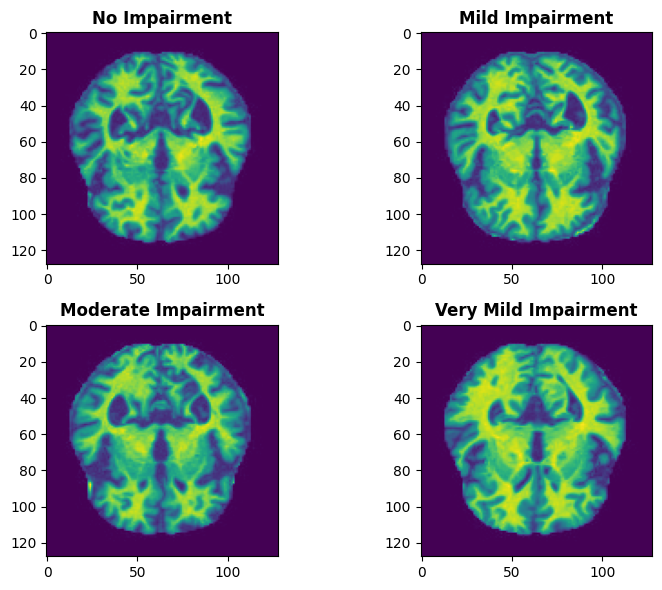

In [6]:
from matplotlib import pyplot as plt
from skimage.io import imread

# Load the images
no_impairment = imread(train_data_path+"/No Impairment"+"/NoImpairment (1).jpg")
mild_impairment = imread(train_data_path+"/Mild Impairment"+"/MildImpairment (1).jpg")
moderate_impairment = imread(train_data_path+"/Moderate Impairment"+"/ModerateImpairment (1).jpg")
very_mild_impairment = imread(train_data_path+"/Very Mild Impairment"+"/VeryMildImpairment (1).jpg")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

axes[0][0].imshow(no_impairment)
axes[0][0].set_title('No Impairment', fontsize=12, weight='bold')

axes[0][1].imshow(mild_impairment)
axes[0][1].set_title('Mild Impairment', fontsize=12, weight='bold')

axes[1][0].imshow(moderate_impairment)
axes[1][0].set_title('Moderate Impairment', fontsize=12, weight='bold')

axes[1][1].imshow(very_mild_impairment)
axes[1][1].set_title('Very Mild Impairment', fontsize=12, weight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

In [7]:
# Data shape
print("Shape of image is -",cv2.imread(train_data_path+"/No Impairment"+"/NoImpairment (1).jpg").shape)

Shape of image is - (128, 128, 3)


## Data Preprocessing

In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(main_folder, train_folder, test_folder, test_size=0.2, random_state=42):
    # Create train and test folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Loop through each class folder in the main folder
    for class_folder in os.listdir(main_folder):
        class_path = os.path.join(main_folder, class_folder)
        if os.path.isdir(class_path):
            # List all files in the class folder
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            # Split the files into training and testing sets
            train_files, test_files = train_test_split(files, test_size=test_size, random_state=random_state)
            # Create subfolders in train and test folders for the current class
            os.makedirs(os.path.join(train_folder, class_folder), exist_ok=True)
            os.makedirs(os.path.join(test_folder, class_folder), exist_ok=True)
            # Move files to train and test subfolders
            for file in train_files:
                shutil.move(os.path.join(class_path, file), os.path.join(train_folder, class_folder, file))
            for file in test_files:
                shutil.move(os.path.join(class_path, file), os.path.join(test_folder, class_folder, file))

# Define paths
main_folder = "/content/Combined Dataset/train"
train_folder = "train_folder"
test_folder = "test_folder"

# Split data
split_data(main_folder, train_folder, test_folder)

In [9]:
def data_preprocessing(output_size):
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                    zoom_range = 0.2,
                                    shear_range = 0.2,
                                    rotation_range=15,
                                    fill_mode='nearest',
                                    horizontal_flip = True)

  test_datagen = ImageDataGenerator(rescale = 1./255)

  training_set = train_datagen.flow_from_directory(train_folder,
                                                  target_size = (output_size, output_size),
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  shuffle=True)

  test_set = test_datagen.flow_from_directory(test_folder,
                                              target_size = (output_size, output_size),
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              shuffle = False)

  return training_set, test_set

## Building Generalize Model

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 conv2d_16 (Conv2D)          (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 75, 75, 64)        36928     
                                                      

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
training_set, test_set = data_preprocessing(output_size=150)
history = model.fit(training_set, validation_data = test_set, batch_size = 64, epochs= 30, verbose = 1)

Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.
Epoch 1/30
256/256 [==============================] - 61s 220ms/step - loss: 1.2760 - accuracy: 0.3516 - val_loss: 1.0285 - val_accuracy: 0.4717
Epoch 2/30
256/256 [==============================] - 59s 232ms/step - loss: 0.7282 - accuracy: 0.6578 - val_loss: 0.6168 - val_accuracy: 0.7261
Epoch 3/30
256/256 [==============================] - 58s 226ms/step - loss: 0.6134 - accuracy: 0.7122 - val_loss: 0.5321 - val_accuracy: 0.7383
Epoch 4/30
256/256 [==============================] - 56s 220ms/step - loss: 0.5321 - accuracy: 0.7505 - val_loss: 0.5167 - val_accuracy: 0.7500
Epoch 5/30
256/256 [==============================] - 56s 219ms/step - loss: 0.5171 - accuracy: 0.7551 - val_loss: 0.4802 - val_accuracy: 0.7749
Epoch 6/30
256/256 [==============================] - 58s 225ms/step - loss: 0.5004 - accuracy: 0.7626 - val_loss: 0.5116 - val_accuracy: 0.7441
Epoch 7/30
256/256 [==========================

In [40]:
model.fit(training_set, validation_data = test_set, batch_size = 64, epochs= 10, verbose = 1)

Epoch 1/10
256/256 [==============================] - 55s 216ms/step - loss: 0.3011 - accuracy: 0.8623 - val_loss: 0.2914 - val_accuracy: 0.8623
Epoch 2/10
256/256 [==============================] - 57s 223ms/step - loss: 0.3173 - accuracy: 0.8604 - val_loss: 0.2900 - val_accuracy: 0.8701
Epoch 3/10
256/256 [==============================] - 56s 220ms/step - loss: 0.3003 - accuracy: 0.8700 - val_loss: 0.2837 - val_accuracy: 0.8682
Epoch 4/10
256/256 [==============================] - 55s 216ms/step - loss: 0.2929 - accuracy: 0.8716 - val_loss: 0.2949 - val_accuracy: 0.8623
Epoch 5/10
256/256 [==============================] - 55s 215ms/step - loss: 0.2957 - accuracy: 0.8644 - val_loss: 0.2869 - val_accuracy: 0.8657
Epoch 6/10
256/256 [==============================] - 59s 229ms/step - loss: 0.2893 - accuracy: 0.8744 - val_loss: 0.2810 - val_accuracy: 0.8745
Epoch 7/10
256/256 [==============================] - 56s 217ms/step - loss: 0.2845 - accuracy: 0.8756 - val_loss: 0.2678 - val_ac

In [41]:
model.save("Alzheimer_88_acc.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Architecture

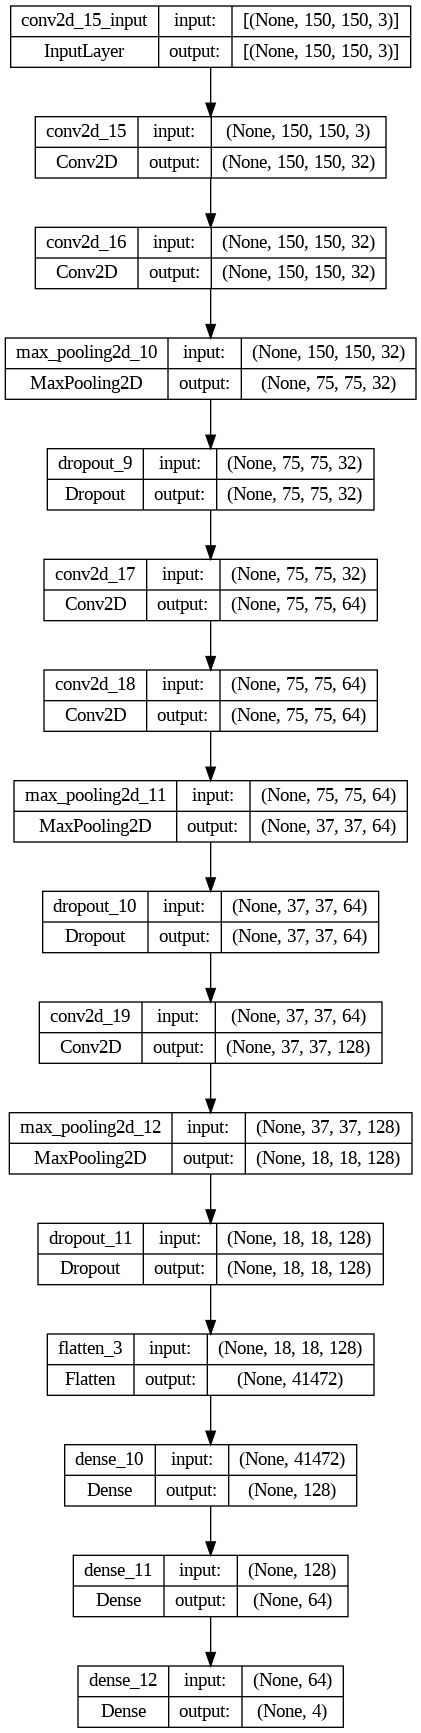

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Training & Validation Accuracy

In [42]:
print("Training Accuracy -", round(history.history['accuracy'][-1]*100,2),"%")
print("Validation Accuracy -", round(history.history['val_accuracy'][-1]*100,2),"%")

Training Accuracy - 85.58 %
Validation Accuracy - 85.3 %


## Plotting the Model History

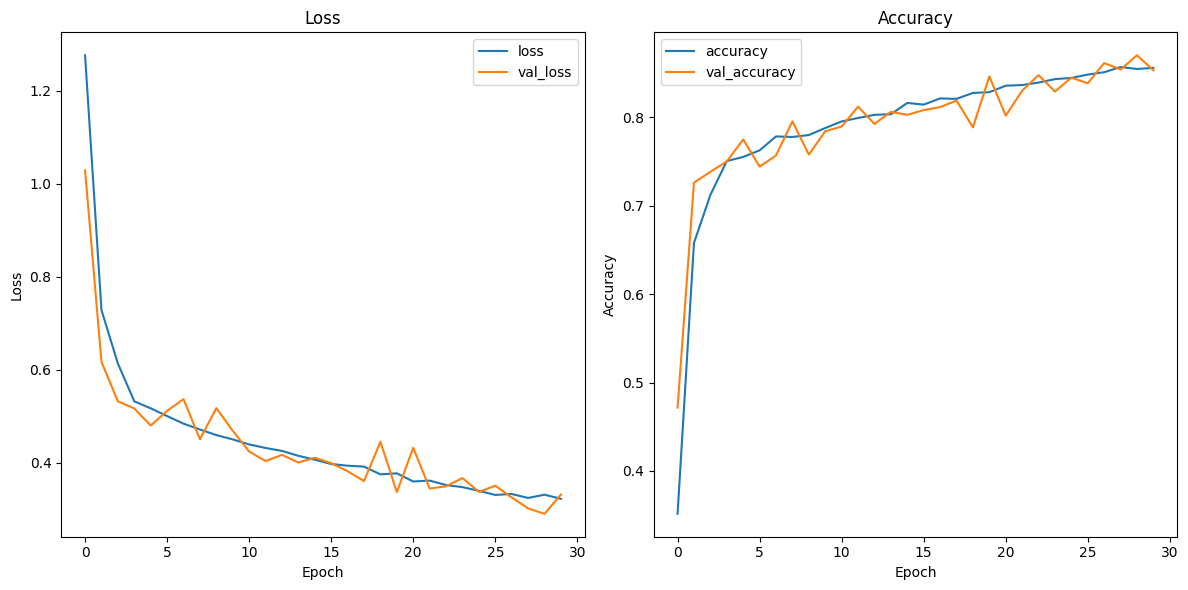

In [27]:
import matplotlib.pyplot as plt

def plotting(history):
    plot_data = pd.DataFrame(history.history)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plotting Loss
    plot_data[['loss', 'val_loss']].plot(ax=axes[0], title='Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    # Plotting Accuracy
    plot_data[['accuracy', 'val_accuracy']].plot(ax=axes[1], title='Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

plotting(history)

## Testing Model

In [28]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def prediction(img_path, class_labels):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to class labels
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]

    # Print predicted class and probabilities
    print("Predicted Class:", predicted_class)
    print("Predicted Probabilities:", prediction[0])

    # Display the image
    sample = plt.imread(img_path)
    plt.imshow(sample)
    plt.show()

## Testing

1/1 [==============================] - 0s 17ms/step
Predicted Class: Mild Impairment
Predicted Probabilities: [0.9543305  0.0278255  0.01498942 0.00285463]


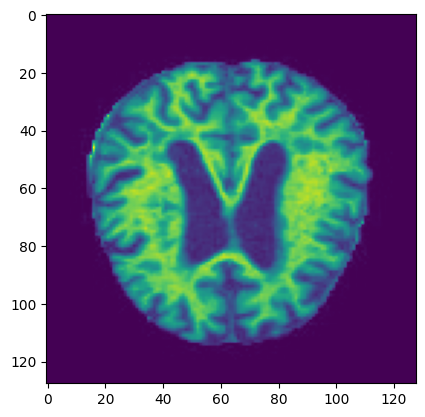

In [51]:
# Example usage:
img_path = "test/Mild Impairment/31 (14).jpg"
class_labels = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]  # List of class labels corresponding to model output
prediction(img_path, class_labels)